In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Sampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as albu
import os, glob, sys, shutil
import cv2, itertools, random, pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import sklearn
from collections import Counter
from numpy.random import choice
from utils.meter import AverageValueMeter

In [2]:
import data_process
import utils
IMAGE_FOLDER = "/data/tcga/512dense/"

# loss

In [3]:
def range_to_anchors_and_delta(precision_range, num_anchors):
    """Calculates anchor points from precision range.
    Args:
        precision_range: an interval (a, b), where 0.0 <= a <= b <= 1.0
        num_anchors: int, number of equally spaced anchor points.
    Returns:
        precision_values: A `Tensor` of [num_anchors] equally spaced values
            in the interval precision_range.
        delta: The spacing between the values in precision_values.
    Raises:
        ValueError: If precision_range is invalid.
    """
    # Validate precision_range.
    if len(precision_range) != 2:
        raise ValueError(
            "length of precision_range (%d) must be 2" % len(precision_range)
        )
    if not 0 <= precision_range[0] <= precision_range[1] <= 1:
        raise ValueError(
            "precision values must follow 0 <= %f <= %f <= 1"
            % (precision_range[0], precision_range[1])
        )

    # Sets precision_values uniformly between min_precision and max_precision.
    precision_values = np.linspace(
        start=precision_range[0], stop=precision_range[1], num=num_anchors + 1
    )[1:]

    delta = (precision_range[1] - precision_range[0]) / num_anchors
    return torch.cuda.FloatTensor(precision_values), delta

In [4]:
def build_class_priors(
    labels,
    class_priors=None,
    weights=None,
    positive_pseudocount=1.0,
    negative_pseudocount=1.0,
):
    """build class priors, if necessary.
    For each class, the class priors are estimated as
    (P + sum_i *w_i *y_i) / (P + N + sum_i *w_i),
    where y_i is the ith label, w_i is the ith weight, P is a pseudo-count of
    positive labels, and N is a pseudo-count of negative labels.
    Args:
        labels: A `Tensor` with shape [batch_size, num_classes].
            Entries should be in [0, 1].
        class_priors: None, or a floating point `Tensor` of shape [C]
            containing the prior probability of each class (i.e. the fraction of the
            training data consisting of positive examples). If None, the class
            priors are computed from `targets` with a moving average.
        weights: `Tensor` of shape broadcastable to labels, [N, 1] or [N, C],
            where `N = batch_size`, C = num_classes`
        positive_pseudocount: Number of positive labels used to initialize the class
            priors.
        negative_pseudocount: Number of negative labels used to initialize the class
            priors.
    Returns:
        class_priors: A Tensor of shape [num_classes] consisting of the
          weighted class priors, after updating with moving average ops if created.
    """
    if class_priors is not None:
        return class_priors

    N, C = labels.size()

    weighted_label_counts = (weights * labels).sum(0)

    weight_sum = weights.sum(0)

    class_priors = torch.div(
        weighted_label_counts + positive_pseudocount,
        weight_sum + positive_pseudocount + negative_pseudocount,
    )

    return class_priors

In [5]:
class LagrangeMultiplier(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()


def lagrange_multiplier(x):
    return LagrangeMultiplier.apply(x)

In [6]:
def weighted_hinge_loss(labels, logits, positive_weights=1.0, negative_weights=1.0):
    """
    Args:
        labels: one-hot representation `Tensor` of shape broadcastable to logits
        logits: A `Tensor` of shape [N, C] or [N, C, K]
        positive_weights: Scalar or Tensor
        negative_weights: same shape as positive_weights
    Returns:
        3D Tensor of shape [N, C, K], where K is length of positive weights
        or 2D Tensor of shape [N, C]
    """
    positive_weights_is_tensor = torch.is_tensor(positive_weights)
    negative_weights_is_tensor = torch.is_tensor(negative_weights)

    # Validate positive_weights and negative_weights
    if positive_weights_is_tensor ^ negative_weights_is_tensor:
        raise ValueError(
            "positive_weights and negative_weights must be same shape Tensor "
            "or both be scalars. But positive_weight_is_tensor: %r, while "
            "negative_weight_is_tensor: %r"
            % (positive_weights_is_tensor, negative_weights_is_tensor)
        )

    if positive_weights_is_tensor and (
        positive_weights.size() != negative_weights.size()
    ):
        raise ValueError(
            "shape of positive_weights and negative_weights "
            "must be the same! "
            "shape of positive_weights is {0}, "
            "but shape of negative_weights is {1}"
            % (positive_weights.size(), negative_weights.size())
        )

    # positive_term: Tensor [N, C] or [N, C, K]
    positive_term = (1 - logits).clamp(min=0) * labels
    negative_term = (1 + logits).clamp(min=0) * (1 - labels)

    if positive_weights_is_tensor and positive_term.dim() == 2:
        return (
            positive_term.unsqueeze(-1) * positive_weights
            + negative_term.unsqueeze(-1) * negative_weights
        )
    else:
        return positive_term * positive_weights + negative_term * negative_weights



In [7]:
class AUCPRHingeLoss(nn.Module):
    """area under the precision-recall curve loss,
    Reference: "Scalable Learning of Non-Decomposable Objectives", Section 5 \
    TensorFlow Implementation: \
    https://github.com/tensorflow/models/tree/master/research/global_objectives\
    """

    def __init__(self, weights=None, precision_range_lower = 0.0, precision_range_upper = 1.0, 
                 num_classes = 2, num_anchors = 20):
        """Args:
        config: Config containing `precision_range_lower`, `precision_range_upper`,
            `num_classes`, `num_anchors`
        """
        nn.Module.__init__(self)
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.precision_range = (
            precision_range_lower,
            precision_range_upper,
        )

        # Create precision anchor values and distance between anchors.
        # coresponding to [alpha_t] and [delta_t] in the paper.
        # precision_values: 1D `Tensor` of shape [K], where `K = num_anchors`
        # delta: Scalar (since we use equal distance between anchors)
        self.precision_values, self.delta = range_to_anchors_and_delta(
            self.precision_range, self.num_anchors
        )

        # notation is [b_k] in paper, Parameter of shape [C, K]
        # where `C = number of classes` `K = num_anchors`
        self.biases = nn.Parameter(
            torch.cuda.FloatTensor(num_classes, num_anchors).zero_()
        )
        self.lambdas = nn.Parameter(
            torch.cuda.FloatTensor(num_classes, num_anchors).data.fill_(
                1.0
            )
        )
    
    @property
    def __name__(self):
        return "AUPRLoss"
    
    def forward(self, logits, targets, reduce=True, size_average=True, weights=None):
        """
        Args:
            logits: Variable :math:`(N, C)` where `C = number of classes`
            targets: Variable :math:`(N)` where each value is
                `0 <= targets[i] <= C-1`
            weights: Coefficients for the loss. Must be a `Tensor` of shape
                [N] or [N, C], where `N = batch_size`, `C = number of classes`.
            size_average (bool, optional): By default, the losses are averaged
                    over observations for each minibatch. However, if the field
                    sizeAverage is set to False, the losses are instead summed
                    for each minibatch. Default: ``True``
            reduce (bool, optional): By default, the losses are averaged or summed over
                observations for each minibatch depending on size_average. When reduce
                is False, returns a loss per input/target element instead and ignores
                size_average. Default: True
        """
        C = 1 if logits.dim() == 1 else logits.size(1)

        # softmax with temperature, large temperater get smooth result
        # logits = torch.softmax(logits/5, 1)
        
        if self.num_classes != C:
            raise ValueError(
                "num classes is %d while logits width is %d" % (self.num_classes, C)
            )

        labels, weights = AUCPRHingeLoss._prepare_labels_weights(
            logits, targets, weights=weights
        )

        # Lagrange multipliers
        # Lagrange multipliers are required to be nonnegative.
        # Their gradient is reversed so that they are maximized
        # (rather than minimized) by the optimizer.
        # 1D `Tensor` of shape [K], where `K = num_anchors`
        lambdas = lagrange_multiplier(self.lambdas)
        # print("lambdas: {}".format(lambdas))

        # A `Tensor` of Shape [N, C, K]
        hinge_loss = weighted_hinge_loss(
            labels.unsqueeze(-1),
            logits.unsqueeze(-1) - self.biases,
            positive_weights=1.0 + lambdas * (1.0 - self.precision_values),
            negative_weights=lambdas * self.precision_values,
        )

        # 1D tensor of shape [C]
        class_priors = build_class_priors(labels, weights=weights)

        # lambda_term: Tensor[C, K]
        # according to paper, lambda_term = lambda * (1 - precision) * |Y^+|
        # where |Y^+| is number of postive examples = N * class_priors
        lambda_term = class_priors.unsqueeze(-1) * (
            lambdas * (1.0 - self.precision_values)
        )

        per_anchor_loss = weights.unsqueeze(-1) * hinge_loss - lambda_term

        # Riemann sum over anchors, and normalized by precision range
        # loss: Tensor[N, C]
        loss = per_anchor_loss.sum(2) * self.delta
        loss /= self.precision_range[1] - self.precision_range[0]

        if not reduce:
            return loss
        elif size_average:
            return loss.mean()
        else:
            return loss.sum()

    @staticmethod
    def _prepare_labels_weights(logits, targets, weights=None):
        """
        Args:
            logits: A tensor of shape [N, C] where `C = number of classes`
            targets: A tensor of shape [N]
            weights: Either `None` or a `Tensor` with shape broadcastable to `logits`
        Returns:
            labels: Tensor of shape [N, C], one-hot representation
            weights: Tensor of shape broadcastable to labels
        """
        N, C = logits.size()
        # Converts targets to one-hot representation. Dim: [N, C]
        labels = torch.cuda.FloatTensor(N, C).zero_().scatter(1, targets.unsqueeze(1).data, 1)
        if weights is None:
            weights = torch.cuda.FloatTensor(N, 1).data.fill_(1.0)

        return labels, weights

In [8]:
def weighted_sigmoid_cross_entropy_with_logits(labels,
                                               logits,
                                               positive_weights=1.0,
                                               negative_weights=1.0,
                                               name=None):
    """Computes a weighting of sigmoid cross entropy given `logits`.
    Measures the weighted probability error in discrete classification tasks in
    which classes are independent and not mutually exclusive.  For instance, one
    could perform multilabel classification where a picture can contain both an
    elephant and a dog at the same time. The class weight multiplies the
    different types of errors.
    For brevity, let `x = logits`, `z = labels`, `c = positive_weights`,
    `d = negative_weights`  The
    weighed logistic loss is
    ```
    c * z * -log(sigmoid(x)) + d * (1 - z) * -log(1 - sigmoid(x))
    = c * z * -log(1 / (1 + exp(-x))) - d * (1 - z) * log(exp(-x) / (1 + exp(-x)))
    = c * z * log(1 + exp(-x)) + d * (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
    = c * z * log(1 + exp(-x)) + d * (1 - z) * (x + log(1 + exp(-x)))
    = (1 - z) * x * d + (1 - z + c * z ) * log(1 + exp(-x))
    =  - d * x * z + d * x + (d - d * z + c * z ) * log(1 + exp(-x))
    ```
    To ensure stability and avoid overflow, the implementation uses the identity
      log(1 + exp(-x)) = max(0,-x) + log(1 + exp(-abs(x)))
    and the result is computed as
    ```
    = -d * x * z + d * x
      + (d - d * z + c * z ) * (max(0,-x) + log(1 + exp(-abs(x))))
    ```
    Note that the loss is NOT an upper bound on the 0-1 loss, unless it is divided
    by log(2).
    Args:
    labels: A `Tensor` of type `float32` or `float64`. `labels` can be a 2D
      tensor with shape [batch_size, num_labels] or a 3D tensor with shape
      [batch_size, num_labels, K].
    logits: A `Tensor` of the same type and shape as `labels`. If `logits` has
      shape [batch_size, num_labels, K], the loss is computed separately on each
      slice [:, :, k] of `logits`.
    positive_weights: A `Tensor` that holds positive weights and has the
      following semantics according to its shape:
        scalar - A global positive weight.
        1D tensor - must be of size K, a weight for each 'attempt'
        2D tensor - of size [num_labels, K'] where K' is either K or 1.
      The `positive_weights` will be expanded to the left to match the
      dimensions of logits and labels.
    negative_weights: A `Tensor` that holds positive weight and has the
      semantics identical to positive_weights.
    name: A name for the operation (optional).
    Returns:
    A `Tensor` of the same shape as `logits` with the componentwise
      weighted logistic losses.
    """

    softplus_term = torch.add(torch.max(-logits, torch.zeros_like(logits)),
                           torch.log(1.0 + torch.exp(-torch.abs(logits))))
    weight_dependent_factor = (
        negative_weights + (positive_weights - negative_weights) * labels)
    return (negative_weights * (logits - labels * logits) +
            weight_dependent_factor * softplus_term)

In [9]:
def _prepare_labels_weights(logits, targets, weights=None):
    """
    Args:
        logits: A tensor of shape [N, C] where `C = number of classes`
        targets: A tensor of shape [N]
        weights: Either `None` or a `Tensor` with shape broadcastable to `logits`
    Returns:
        labels: Tensor of shape [N, C], one-hot representation
        weights: Tensor of shape broadcastable to labels
    """
    N, C = logits.size()
    # Converts targets to one-hot representation. Dim: [N, C]
    labels = torch.cuda.FloatTensor(N, C).zero_().scatter(1, targets.unsqueeze(1).data, 1)
    if weights is None:
        # Weights has shape [batch_size]. Reshape to [batch_size, 1].
        weights = torch.cuda.FloatTensor(N, 1).data.fill_(1.0)
    elif weights.dim() == 0:
        # Weights is a scalar. Change shape of weights to match logits.
        weights *= torch.ones_like(logits)
    return labels, weights

In [10]:
class AUROCLoss(nn.Module):
    def __init__(self, num_classes = 1):
        """ Computes ROC AUC loss == area above AUC.
        The area under the ROC curve is the probability p that a randomly chosen
        positive example will be scored higher than a randomly chosen negative
        example.
        This loss approximates 1-p by using a surrogate (either hinge loss or
        cross entropy) for the indicator function. Specifically, the loss is:
        sum_i sum_j w_i*w_j*loss(logit_i - logit_j)
        """
        nn.Module.__init__(self)
        self.num_classes = num_classes
 
    @property
    def __name__(self):
        return "AUROCLoss"
    
    def forward(self, logits, targets, weights=None, surrogate_type="xent"):
        """
        Args:
            logits: A tensor of shape [N, C] where `C = number of classes`
            targets: A tensor of shape [N] where each value is `0 <= targets[i] <= C-1`
            weights: Coefficients for the loss. Must be a `Tensor` of shape
                [N] or [N, C], where `N = batch_size`, `C = number of classes`.
            surrogate_type: Either 'xent' or 'hinge', specifying which upper bound
                should be used for the indicator function.
            
        """
        C = 1 if logits.dim() == 1 else logits.size(1)

        if self.num_classes != C:
            raise ValueError(
                "num classes is %d while logits width is %d" % (self.num_classes, C)
            )
        labels, weights = _prepare_labels_weights(
            logits, targets, weights=weights
        )
        # Create tensors of pairwise differences for logits and labels, and
        # pairwise products of weights. These have shape [N, N, C].
        logits_difference = torch.unsqueeze(logits, 0) - torch.unsqueeze(logits, 1)
        labels_difference = torch.unsqueeze(labels, 0) - torch.unsqueeze(labels, 1)
        weights_product = torch.unsqueeze(weights, 0) * torch.unsqueeze(weights, 1) 
        
        signed_logits_difference = labels_difference * logits_difference
        if surrogate_type == "hinge":
            raw_loss = weighted_hinge_loss(
                labels=torch.ones_like(signed_logits_difference),
                logits=signed_logits_difference
            )
        elif surrogate_type == "xent":
            raw_loss = weighted_sigmoid_cross_entropy_with_logits(
                labels=torch.ones_like(signed_logits_difference),
                logits=signed_logits_difference
            )
        weighted_loss = weights_product * raw_loss
        # Zero out entries of the loss where labels_difference zero (so loss is only
        # computed on pairs with different labels).
        loss = (torch.abs(labels_difference) * weighted_loss).mean() * 0.5
        return loss

# data

In [21]:
with open("./cohort_high_low.pkl", "rb") as fp:
    cohort_count_dict = pickle.load(fp)
print('# of Patient :{}'.format(len(cohort_count_dict)))

# of Patient :389


In [22]:
patient_ids = list(cohort_count_dict.keys())
patient_cls = list(cohort_count_dict.values())
lookup = dict(zip(patient_ids, patient_cls))
Counter(patient_cls)

Counter({0: 317, 1: 72})

In [23]:
train_patient, valid_patient = train_test_split(patient_ids, test_size = 0.2, random_state = 42)
print(len(train_patient), len(valid_patient))
print("train", Counter([cohort_count_dict[i] for i in train_patient]))
print("valid", Counter([cohort_count_dict[i] for i in valid_patient]))

311 78
train Counter({0: 254, 1: 57})
valid Counter({0: 63, 1: 15})


In [14]:
train_images = []
valid_images = []

train_gt = [0,0]
valid_gt = [0,0]
# using_npy = "/data/tcga/512denseTumor/"
using_npy = "/data/tcga/kmeans_cluster_32/"

for npy in glob.glob(os.path.join(using_npy, "*.npy")):
    
    x_y_pairs = np.load(npy)
    
    if using_npy == "/data/tcga/kmeans_cluster_32/":
        x_y_pairs = np.reshape(x_y_pairs, (x_y_pairs.shape[0]*x_y_pairs.shape[1], -1))
    
    svs_name = npy.split("/")[-1][:-4]
    if svs_name[:12] not in cohort_count_dict.keys():
        continue
    patient = svs_name[:12]
    for x, y in x_y_pairs:
        path = "{}_{}_{}.jpg".format(svs_name, x, y)
        if patient in train_patient:
            train_images.append(path)
            if lookup[path[:12]] == 1:
                train_gt[1]+=1
            else:
                train_gt[0]+=1
        else:
            valid_images.append(path)
            if lookup[path[:12]] == 1:
                valid_gt[1]+=1
            else:
                valid_gt[0]+=1

train_images = np.array(train_images)
valid_images = np.array(valid_images)

print('# of train:{}\n# of valid:{}'.format(
    len(train_images), len(valid_images)))
print('# of train neg:{}\n# of train pos:{}\n# of valid neg:{}\n# of valid pos:{}'.format(
    train_gt[0], train_gt[1], valid_gt[0], valid_gt[1]))

# of train:1159232
# of valid:290944
# of train neg:932640
# of train pos:226592
# of valid neg:211296
# of valid pos:79648


# Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, patches, augmentation = None, preprocessing = None):
        self.patches = patches
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):
        image_name = self.patches[i]
        svs_name = image_name.split("_")[0]
        full_path = os.path.join(IMAGE_FOLDER, svs_name, image_name)
        image = data_process.wsi_utils.vips_get_image(full_path)
        
        cls = lookup[image_name[:12]]
        
        if(self.augmentation):
            sampled = self.augmentation(image = image)
            _input = sampled['image']
            
        if(self.preprocessing):
            sampled = self.preprocessing(image = _input)
            _input = sampled['image']
            
        return _input, cls, image_name[:-4]
    
    def get_index(self):
        positive_index = []
        count = 0
        for i in range(self.__len__()):
            image_name = self.patches[i]
            
            if lookup[image_name[:12]] == 1:
                positive_index.append(i)
        
        negative_indedx = list(sorted(set(range(len(self.patches))) - set(positive_index)))
        return positive_index, negative_indedx
            
    def __len__(self):
        return len(self.patches)

In [12]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing():
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    test_transform = [
        albu.Resize(224, 224),
        albu.Flip(),
        albu.ShiftScaleRotate(border_mode=0, value=0),
        albu.HueSaturationValue(hue_shift_limit=40, p=0.8),
        albu.RandomBrightnessContrast(p=0.8),
        albu.Normalize()
    ]
    return albu.Compose(test_transform)

def get_validation_augmentation():
    test_transform = [
        albu.Resize(224, 224),
        albu.Normalize()
        #albu.ToGray(p = 1.)
    ]
    return albu.Compose(test_transform)

In [17]:
train_dataset = CustomDataset(
    patches = train_images,
    augmentation = get_training_augmentation(),
    preprocessing = get_preprocessing(),
)

validation_dataset = CustomDataset(
    patches = valid_images,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


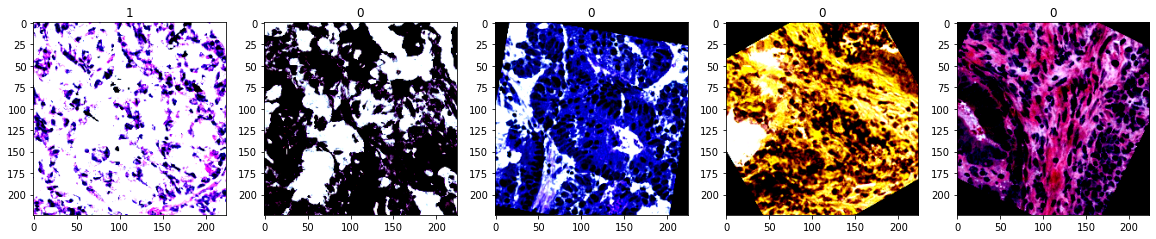

In [18]:
plt.figure(figsize=(20,10))

for i in range(5):
    import random
    rand = random.randint(0, len(validation_dataset))
    s_img, cls, patch_name = train_dataset[rand]
    plt.subplot(2, 5, i+1)
    plt.title(cls)
    plt.imshow(s_img.transpose(1, 2, 0))

# dataloader

In [13]:
class TwoStreamBatchSampler(Sampler):
    def __init__(self, primary_indices, secondary_indices, batch_size, secondary_batch_size):
        self.primary_indices = primary_indices
        self.secondary_indices = secondary_indices
        self.secondary_batch_size = secondary_batch_size
        self.primary_batch_size = batch_size - secondary_batch_size

        assert len(self.primary_indices) >= self.primary_batch_size > 0
        assert len(self.secondary_indices) >= self.secondary_batch_size > 0

    def __iter__(self):
        primary_iter = iterate_once(self.primary_indices)
        secondary_iter = iterate_eternally(self.secondary_indices)
        return (
            primary_batch + secondary_batch
            for (primary_batch, secondary_batch)
            in  zip(grouper(primary_iter, self.primary_batch_size),
                    grouper(secondary_iter, self.secondary_batch_size))
        )

    def __len__(self):
        return len(self.primary_indices) // self.primary_batch_size

def iterate_once(iterable):
    return np.random.permutation(iterable)


def iterate_eternally(indices):
    def infinite_shuffles():
        while True:
            yield np.random.permutation(indices)
    return itertools.chain.from_iterable(infinite_shuffles())


def grouper(iterable, n):
    # grouper('ABCDEFG', 3) --> ABC DEF"
    args = [iter(iterable)] * n
    return zip(*args)

In [20]:
batch_size = 128

#sampler
# positive_index, negative_indedx = train_dataset.get_index()
# print('# of train Positive Labeled :{}, # of train Negative Labeled :{}'.format(len(positive_index), len(negative_indedx)))
# batch_sampler = TwoStreamBatchSampler(
#     positive_index, negative_indedx, batch_size, int(batch_size * len(negative_indedx)/(len(positive_index)+len(negative_indedx))))
# train_loader = DataLoader(
#     train_dataset, 
#     num_workers=16, 
#     pin_memory=True, 
#     batch_sampler=batch_sampler
# )
# positive_index, negative_indedx = validation_dataset.get_index()
# print('# of train Positive Labeled :{}, # of train Negative Labeled :{}'.format(len(positive_index), len(negative_indedx)))
# batch_sampler = TwoStreamBatchSampler(
#     positive_index, negative_indedx, batch_size, int(batch_size * len(negative_indedx)/(len(positive_index)+len(negative_indedx))))

# valid_loader = DataLoader(
#     validation_dataset, 
#     num_workers=16, 
#     pin_memory=True, 
#     batch_sampler=batch_sampler
# )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

# Training setting

In [22]:
num_classes = 2
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
from datetime import datetime
from pytz import timezone    


DEVICE = 'cuda:0'

taipei = timezone('Asia/Taipei')
taipei_time = datetime.now(taipei)
current_time = taipei_time.strftime('%Y-%m-%d_%H')

# loss_fn = CrossEntropyLoss()
# loss_fn = AUCPRHingeLoss(num_classes=num_classes)
loss_fn = AUROCLoss(num_classes=num_classes)

# metrics = [utils.metrics.Fscore(), utils.loss.BCEWithLogits()]
metrics = [utils.metrics.Fscore(), utils.loss.CrossEntropy()]

# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=1e-4),
# ], weight_decay=1e-2)

optimizer = torch.optim.SGD([ 
    dict(params=model.parameters(), lr=1e-4),
], weight_decay=1e-2,  momentum=0.9)

model_name = "ResNet18_{}".format("AUROCCELoss_sgd")
log_folder_name = os.path.join('/home/Tsung/pathology/log_folder/',current_time + model_name)

## tensorboard

In [24]:
from torch.utils.tensorboard import SummaryWriter
# Writer
writer = SummaryWriter(log_dir=log_folder_name, flush_secs=3)

# epoch

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

In [15]:
class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device='cpu', verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
        s = ', '.join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass
    
    def run(self, dataloader, epoch):
        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}
        patient_pred = {}
        all_patch_pred = []
        all_patch_gt = []
        with tqdm(dataloader, desc=self.stage_name, file=sys.stdout, disable=not (self.verbose)) as iterator:
            for x, y, patch_name in iterator:
                patch_name = list(patch_name)
                x, y = x.to(self.device), y.to(self.device)
                cls_loss, pred = self.batch_update(x, y)
                
                temp_pred = torch.softmax(pred, dim = 1)
                temp_pred = temp_pred[:, 1].detach().cpu().numpy().tolist()
#                 temp_pred = torch.sigmoid(pred).detach().cpu().numpy().squeeze()
                 
                for p, p_n, patch_gt in zip(temp_pred, patch_name, y):
                    # patch predict
                    all_patch_pred.append(p)
                    all_patch_gt.append(patch_gt.cpu().numpy())
                    
                    p_id = p_n[:12]
                    if(p_id not in patient_pred):
                        patient_pred[p_id] = [0, 0]
                    if(p > 0.5):
                        patient_pred[p_id][1] += 1
                    else:
                        patient_pred[p_id][0] += 1
                
                # update teacher loss logs
                loss_value = cls_loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)
                
                # update teacher metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)                
                
                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)
                    
        y_pred = []
        y_gt = []
        # voting
        for key, values in patient_pred.items():
            y_gt.append(lookup[key])
            d = values[0] + values[1]
            y_pred.append(values[1] / d)
            
        auc = sklearn.metrics.roc_auc_score(y_gt, y_pred)
        precision, recall, _thresholds = sklearn.metrics.precision_recall_curve(y_gt, y_pred)
        aupr = sklearn.metrics.auc(recall, precision)
        
        y_gt = np.array(y_gt)
        y_pred = np.where(np.array(y_pred) > 0.5, 1, 0)
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_gt, y_pred).ravel()
       
        print('patient AUROC : ', auc)
        print('patient AUPR : ', aupr)
        print("tn: {} fp: {} fn:{} tp:{}".format(tn, fp, fn, tp))
        
        patch_auc = sklearn.metrics.roc_auc_score(all_patch_gt, all_patch_pred)
        precision, recall, _thresholds = sklearn.metrics.precision_recall_curve(all_patch_gt, all_patch_pred)
        patch_aupr = sklearn.metrics.auc(recall, precision)
        print('patches AUROC : ', patch_auc)  
        print('patches AUPR : ', patch_aupr)  
        
        logs.update({'auc' : auc})
        logs.update({'aupr' : aupr})
        
        writer.add_scalar(self.stage_name+'\n' + self.loss.__name__, loss_meter.mean, epoch)
        writer.add_scalar(self.stage_name+'\n' + "AUC", auc, epoch)
        writer.add_scalar(self.stage_name+'\n' + "AUPR", aupr, epoch)
        writer.add_scalar(self.stage_name+'\n' + self.metrics[0].__name__, metrics_meters[self.metrics[0].__name__].mean, epoch)
        writer.add_scalar(self.stage_name+'\n' + "patch AUC", patch_auc, epoch)
        writer.add_scalar(self.stage_name+'\n' + "patch AUPR", patch_aupr, epoch)   
        return logs

In [16]:
class TrainEpoch(Epoch):

    def __init__(self, model, loss, metrics, optimizer, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='train',
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        
        return loss, prediction

In [17]:
class ValidEpoch(Epoch):

    def __init__(self, model, loss, metrics, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='valid',
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

# train

In [29]:
train_epoch = TrainEpoch(
    model, 
    loss_fn,
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model,
    loss_fn,
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [30]:
max_epoch = 10
max_score = 0.6
data_from = "tmb_gmmGT_MKmeansData"

for i in range(0, max_epoch) :
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader, i)
    
    valid_logs = valid_epoch.run(valid_loader, i)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['auc']:
        max_score = valid_logs['auc']
        
        output_path = '/home/Tsung/pathology/weight/{}_{}_{}_epoch_{}_auc_{:.4f}.h5'.format(
            current_time, data_from, model_name, i, valid_logs['auc'])
        
        torch.save(model.state_dict(), output_path)
        
        print('Model saved! {}'.format(output_path))


Epoch: 0
train: 100%|██████████| 9057/9057 [22:44<00:00,  6.64it/s, AUROCLoss - 0.08736, fscore - 0.3388, CrossEntropyLoss - 0.4787]
patient AUROC :  0.7533499102085923
patient AUPR :  0.5456016151090937
tn: 254 fp: 0 fn:54 tp:3
patches AUROC :  0.7032966330517705
patches AUPR :  0.3700253308973565
valid: 100%|██████████| 2273/2273 [04:26<00:00,  8.52it/s, AUROCLoss - 0.002798, fscore - 0.2253, CrossEntropyLoss - 0.8307]
patient AUROC :  0.7386243386243387
patient AUPR :  0.5335244392530716
tn: 62 fp: 1 fn:13 tp:2
patches AUROC :  0.579173934477706
patches AUPR :  0.3978614975084363
Model saved! /home/Tsung/pathology/weight/2020-12-20_20_tmb_gmmGT_MKmeansData_ResNet18_AUROCCELoss_sgd_epoch_0_auc_0.7386243386243387.h5

Epoch: 1
train: 100%|██████████| 9057/9057 [22:52<00:00,  6.60it/s, AUROCLoss - 0.06978, fscore - 0.4389, CrossEntropyLoss - 0.4242]
patient AUROC :  0.823663489432242
patient AUPR :  0.6465900000947375
tn: 254 fp: 0 fn:49 tp:8
patches AUROC :  0.7899355384022773
patches

# Valid

In [18]:
weight = "/data/weight/2020-12-20_17_tmb_gmmGT_MKmeansData_ResNet18_AUCPRHingeLoss_sgd_epoch_4_auc_0.8804232804232803.h5"
# weight = "/data/weight/2020-12-10_00_tmb_gmmGT_MKmeansData_Baseline_epoch_8_auc_0.8560846560846561.h5"

In [31]:
with open("/data/tcga/cohort_count.pkl", "rb") as fp:
    raw_TMB_dict = pickle.load(fp)

In [19]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(weight))
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# using_npy = "/data/tcga/kmeans_cluster_32/"
using_npy = "/data/tcga/512denseTumor/"
valid_npy_pos = []
valid_npy_neg = []
for npy in sorted(glob.glob(os.path.join(using_npy, "*.npy"))):    
    patient = npy.split("/")[-1][:12]
    if patient in valid_patient:
        if lookup[patient] == 1:
            valid_npy_pos.append(npy)
        else:
            valid_npy_neg.append(npy)

In [ ]:
TT_positive_pred = {}
with tqdm(valid_npy_pos, desc="test", file=sys.stdout) as iterator:
    for npy in iterator:
        svs_name = npy.split("/")[-1][:-4]
        patient_name = svs_name[:12]
        x_y_pairs = np.load(npy)
        image_names = ["{}_{}_{}.jpg".format(svs_name, x, y) for x, y in x_y_pairs]
        
        test_dataset = CustomDataset(
            image_names,
            augmentation=get_validation_augmentation(),
            preprocessing=get_preprocessing()
        )
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16, pin_memory=True)
        patch_predictions = np.array([])
        svs_pred = [0,0]
        for images, labels, patch_names in test_loader:
            with torch.no_grad():
                outputs = model.forward(images.cuda())
            outputs = torch.softmax(outputs, dim=1)
            outputs = outputs[:, 1].detach().cpu().numpy()
            patch_predictions = np.concatenate((patch_predictions, outputs))
            for p in outputs:
                if p > 0.5:
                    svs_pred[1] += 1
                else:
                    svs_pred[0] += 1
        y_pred = svs_pred[1]/(svs_pred[0]+svs_pred[1])
        if patient_name not in TT_positive_pred:
            TT_positive_pred[patient_name] = []
        TT_positive_pred[patient_name].append(y_pred)
        
        title = "{}_gt={}_pred={:.4f}_raw={}".format(svs_name, lookup[patient_name], y_pred, raw_TMB_dict[patient_name])
        data_process.stitch.stitch(wsi_name = svs_name, x_y_pairs = x_y_pairs, preds = patch_predictions, title=title)

In [ ]:
TT_negative_pred = {}
with tqdm(valid_npy_neg, desc="test", file=sys.stdout) as iterator:
    for npy in iterator:
        svs_name = npy.split("/")[-1][:-4]
        patient_name = svs_name[:12]
        x_y_pairs = np.load(npy)
        image_names = ["{}_{}_{}.jpg".format(svs_name, x, y) for x, y in x_y_pairs]
        
        test_dataset = CustomDataset(
            image_names,
            augmentation=get_validation_augmentation(),
            preprocessing=get_preprocessing()
        )
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16, pin_memory=True)
        patch_predictions = np.array([])
        svs_pred = [0,0]
        for images, labels, patch_names in test_loader:
            with torch.no_grad():
                outputs = model.forward(images.cuda())
            outputs = torch.softmax(outputs, dim=1)
            outputs = outputs[:, 1].detach().cpu().numpy()
            patch_predictions = np.concatenate((patch_predictions, outputs))
            for p in outputs:
                if p > 0.5:
                    svs_pred[1] += 1
                else:
                    svs_pred[0] += 1
        y_pred = svs_pred[1]/(svs_pred[0]+svs_pred[1])
        if patient_name not in TT_negative_pred:
            TT_negative_pred[patient_name] = []
        TT_negative_pred[patient_name].append(y_pred)
        
        title = "{}_gt={}_pred={:.4f}_raw={}".format(svs_name, lookup[patient_name], y_pred, raw_TMB_dict[patient_name])
        data_process.stitch.stitch(wsi_name = svs_name, x_y_pairs = x_y_pairs, preds = patch_predictions, title=title)

In [ ]:
import sklearn
preds = [np.amax(values) for key, values in TT_positive_pred.items()] \
        + [np.amax(values) for key, values in TT_negative_pred.items()]
gt = [1]*len(TT_positive_pred) + [0]*len(TT_negative_pred)
print(sklearn.metrics.roc_auc_score(gt, preds))